# Bitcoin & Twitter

In [ ]:
from pyspark import SparkContext
from pyspark.sql.types import *
from pyspark.sql import *
from pyspark.sql.functions import col, desc, asc, lit
from pyspark.sql import functions as F
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc
import re
import yfinance as yf
import datetime

# sc = SparkContext("local").getOrCreate()
sqlContext = SQLContext(sc)
spark = SparkSession(sc)
plt.style.use('ggplot')

## Data Exploration

### BITCOIN

 - Unix Timestamp - Date represented as epoc value
 - Date - date and time when the data point was collected
 - Symbol - Symbol of the currency
 - Open - Open value of the currency
 - High - Highest value of currency in the given minute
 - Low - Lowest value of currency in the given minute
 - Close - Close value of the currency in the given minute
 - Volume - Volume of the currency transacted in the given minute.

### TWITTER

 - user_name    The name of the user, as they’ve defined it.
 - user_location    The user-defined location for this account’s profile.
 - user_description	The user-defined UTF-8 string describing their account.
 - user_created	Time and date, when the account was created.
 - user_followers	The number of followers an account currently has.
 - user_friends	The number of friends a account currently has.
 - user_favourites	The number of favorites a account currently has
 - user_verified    When true, indicates that the user has a verified account
 - date UTC time and date when the Tweet was created
 - text The actual UTF-8 text of the Tweet
 - hashtags	All the other hashtags posted in the tweet along with #Bitcoin & #btc
 - source   Utility used to post the Tweet, Tweets from the Twitter website have a source value - web
 - is_retweet	Indicates whether this Tweet has been Retweeted by the authenticating user.

In [ ]:
tweets_schema = StructType([
    StructField('user_name', StringType(), True),
    StructField('user_location', StringType(), True),
    StructField('user_description', StringType(), True),
    StructField('user_created', StringType(), True),
    StructField('user_followers', FloatType(), True),
    StructField('user_friends', IntegerType(), True),
    StructField('user_favourites', IntegerType(), True),
    StructField('user_verified', BooleanType(), True),
    StructField('date', StringType(), True),
    StructField('text', StringType(), True),
    StructField('hashtags', StringType(), True),
    StructField('source', StringType(), True),
    StructField('is_retweet', BooleanType(), True),
])


tweets_df = spark.read.csv(
    "./data/tweets.csv", 
    header=True,
    sep=',',
    multiLine=True,
    schema=tweets_schema

)
tweets_df.show(3)

In [ ]:
# tweets_df = tweets_df.withColumn("date", datetime.datetime.strptime(str(col('date')), '%Y-%m-%d').strftime('%d/%m/%y')).filter((tweets_df.date > datetime.datetime(2020, 3, 20) )& (tweets_df.date < datetime.datetime(2021,9,10)))
tweets_df = tweets_df.withColumn("date", F.to_date(F.col("date"))).filter((tweets_df.date > datetime.datetime(2020, 3, 20) )& (tweets_df.date < datetime.datetime(2021,9,10)))
btc_stock=yf.Ticker("BTC-USD")
start = tweets_df.agg({"date": "min"}).collect()[0]
end = tweets_df.agg({"date": "max"}).collect()[0]
# print(datetime.datetime.strptime(str(start), '%Y-%m-%d'))
# print(datetime.datetime.strptime(str(end), '%Y-%m-%d'))
print(start['min(date)'])
print(end['max(date)'])
btc_stock = btc_stock.history(start=start['min(date)'], end=end['max(date)'])
btc_df = spark.createDataFrame(btc_stock)
btc_df.show()

## Bitcoin

##### Open

In [ ]:
btc_df.describe(["Open"]).show()

##### High

In [ ]:
btc_df.describe(["High"]).show()

##### Low

In [ ]:
btc_df.describe(["Low"]).show()

##### Close

In [ ]:
btc_df.describe(["Close"]).show()

##### Volume

In [ ]:
btc_df.describe(["Volume"]).show()

## TWITTER

In [ ]:
tweets_df.count()

##### user_name
Should be dropped

In [ ]:
tweets_df.drop("user_name")

##### user_location

In [ ]:
tweets_df.select(F.countDistinct("user_location")).show()
tweets_df.select([F.count(F.when(col("user_location").isNull(), "user_location"))]).show()

##### user_description

Should be dropped

In [ ]:
tweets_df.drop("user_description")

##### user_created

In [ ]:
tweets_df.describe(["user_created"]).show()

tweets_df.select([F.count(F.when(col("user_created").isNull(), "user_created"))]).show()

##### user_followers

In [ ]:
tweets_df.select([F.count(F.when(col("user_followers").isNull(), "user_followers"))]).show()

##### user_followers

In [ ]:
tweets_df.select([F.count(F.when(col("user_followers").isNull(), "user_followers"))]).show()

##### user_friends

In [ ]:
tweets_df.select([F.count(F.when(col("user_friends").isNull(), "user_friends"))]).show()

##### user_favourites

In [ ]:
tweets_df.select([F.count(F.when(col("user_favourites").isNull(), "user_favourites"))]).show()

##### user_verified

In [ ]:
tweets_df.select(F.count(F.when(col("user_verified").isNull(), "user_verified")),
                 F.count(F.when(col("user_verified") == "false", "user_verified")),
                 F.count(F.when(col("user_verified") == "true", "user_verified"))).show()

##### date

In [ ]:
tweets_df.select(F.countDistinct("date")).show()
tweets_df.select([F.count(F.when(col("date").isNull(), "date"))]).show()

##### text

In [ ]:
tweets_df.select(F.count(F.when(col("text").isNull(), "text"))).show()

##### hashtags

In [ ]:
tweets_df.select(F.countDistinct("hashtags")).show()
tweets_df.select([F.count(F.when(col("hashtags").isNull(), "hashtags"))]).show()

##### source

In [ ]:
tweets_df.select(F.countDistinct("source")).show()
tweets_df.select([F.count(F.when(col("source").isNull(), "source"))]).show()

##### is_retweet

In [ ]:
tweets_df.select(F.count(F.when(col("is_retweet").isNull(), "is_retweet")).alias("null values"),
                 F.count(F.when(col("is_retweet") == "false", "is_retweet")),
                 F.count(F.when(col("is_retweet") == "true", "is_retweet"))).show()

## Preparing Data    Date|
+-------+-------------+

In [ ]:
from pyspark.sql.functions import udf

def conv_to_int(val):
    if isinstance(val, str):
        return 0
    else:
        return float(val)

conv_to_int_udf = udf(lambda x : conv_to_int(x), IntegerType())

tweets_df = tweets_df.withColumn("user_followers", conv_to_int_udf(col("user_followers")))\
    .withColumn("user_friends", conv_to_int_udf(col("user_friends")))\
    .withColumn("user_favourites", conv_to_int_udf(col("user_favourites")))

### Text cleaning

In [ ]:
def clean_text(text):
    if(isinstance(text, str)):
        text = text.replace("#","")
        text = re.sub('\\n', '', text)
        text = re.sub('https:\/\/\S+', '', text)
        return text
    else:
        return ""

clean_text_udf = udf(lambda x : clean_text(x), StringType())

tweets_df.withColumn("text", clean_text_udf(col("text")))

### Generating impact score

In [ ]:
from pyspark.sql.functions import struct

def generate_impact_score(tweet):
    coef_verified = 1.1 if tweet.user_verified else 1
    coef_hashtags = 1+(tweet.hashtags_len/20)
    return ((tweet.user_followers + (tweet.user_friends/4))*coef_verified*coef_hashtags)/100

generate_impact_score_udf = udf(lambda x : generate_impact_score(x), FloatType())

tweets_df.withColumn("impact_score", generate_impact_score_udf(struct([tweets_df[x] for x in tweets_df.columns])))

## Data visualisation

### Twitter

### Tweets / user

In [ ]:
%matplotlib inline

user_volume = tweets_df.groupby("user_name").count().sort(desc("count"))

n = 10
x_rows = user_volume.limit(n).select("user_name").collect()
x = list(map(lambda r : str(r['user_name']), x_rows))

y_rows = user_volume.limit(n).select("count").collect()
y = list(map(lambda r : int(r['count']), y_rows))

rc('figure', figsize=(25, 15))
fig, ax = plt.subplots()
ax.plot(x, y,
        label='tweets per user')

ax.set_xlabel('username')
ax.set_ylabel('# tweets')
ax.legend()

### Bitcoin Value

In [ ]:
df_location = tweets_df.groupBy('user_location').count().sort(col("count").desc()).show()

In [130]:
date_df = tweets_df.withColumn("date", F.to_date(F.col("date")))
date_df = date_df. groupby("date").count().dropna().sort(asc("date")).filter((date_df.date > datetime.datetime(2020, 3, 20) )& (date_df.date < datetime.datetime.today()))
date_df.sort(desc("date")).show(1)
date_df.sort(asc("date")).show(1)
x_rows = date_df.select("date").collect() 
x = list(map(lambda r : (r['date']), x_rows)) 
y_rows = date_df.select("count").collect() 
tweets_y = list(map(lambda r : int(r['count']), y_rows))

+----------+-----+
|      date|count|
+----------+-----+
|2021-08-26|39011|
+----------+-----+
only showing top 1 row

+----------+-----+
|      date|count|
+----------+-----+
|2021-01-07|    1|
+----------+-----+
only showing top 1 row



In [ ]:
y_rows = btc_df.select("Volume").collect() 
btc_y = list(map(lambda r : float(r['Volume']), y_rows))

In [ ]:
print(btc_df.select("Volume").count())
print(len(tweets_y))

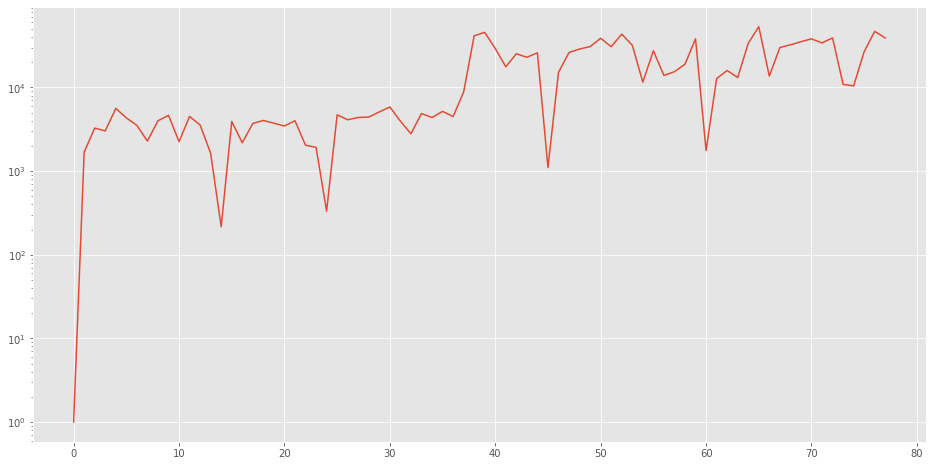

In [131]:
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(tweets_y,label='Tweet Volume')
ax.set_yscale('log')
ax.tick_params(axis='y')
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

plt.show()

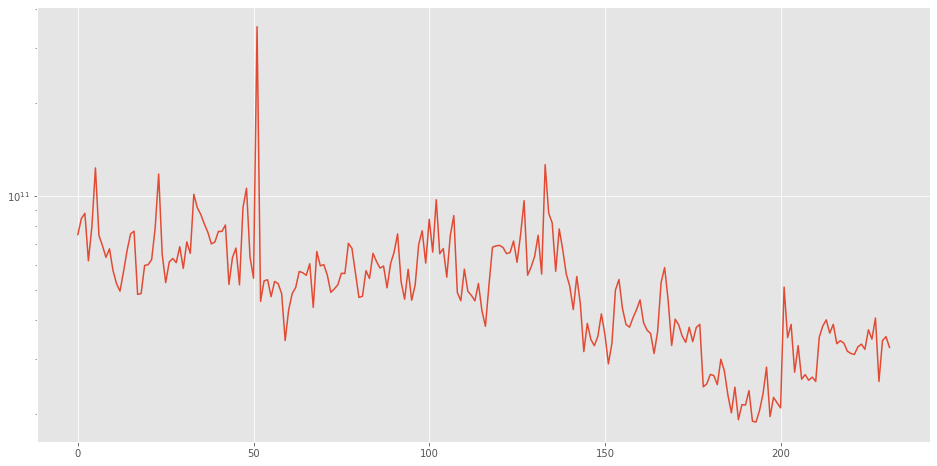

In [132]:
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(btc_y,label='Tweet Volume')
ax.set_yscale('log')
ax.tick_params(axis='y')

ax2.plot(btc_y,color='orange',label='Volume')
ax2.tick_params(axis='y')
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines2,labels2, loc=0)
plt.show()